<a href="https://colab.research.google.com/github/Aerospace87/ML-projects/blob/main/tensorflow/Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf

In [2]:
code_dict = {
    "Caterpillar Inc.": "CAT",
    "CNH Industrial N.V.": "CNH",
    "GE Aerospace" :"GE"
}

cat = yf.Ticker(code_dict["GE Aerospace"])

In [3]:
# get historical market data
hist = cat.history(period="max")

In [4]:
hist.drop(columns=["Volume", "Stock Splits", "Dividends"], inplace=True)

<Axes: xlabel='Date'>

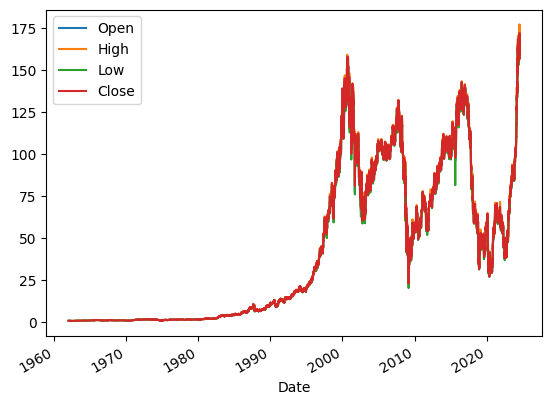

In [5]:
hist.reset_index().plot(x="Date",y=hist.columns)

In [6]:
hist.describe()

,Open,High,Low,Close
count,15749.000000,15749.000000,15749.000000,15749.000000
mean,41.192472,41.630597,40.733393,41.188287
std,44.881839,45.332534,44.419423,44.886000
min,0.469601,0.477004,0.459024,0.469601
25%,1.399638,1.409738,1.388530,1.399638
50%,17.362541,17.480647,17.173563,17.386171
75%,78.996942,79.908898,78.144118,79.072937
max,171.500000,177.199997,167.815951,172.000000
